In [1]:
import graphviz
import pydot
import pywrapfst as pfst
# import fst
import nltk
import re
import os

In [2]:
LexM = pfst.Fst.read("lex_model/lex-uw.fst")
LM_expr = "^(.*)\.pru$"
folder_name = "lang_model"
file_list = [os.path.join(folder_name, fname) for fname in os.listdir(folder_name)]
pruned_models = [re.match(LM_expr, filename).group(1) for filename in file_list if re.match(LM_expr, filename)]

In [3]:
pruned_models

['lang_model/3-gram-1',
 'lang_model/3-gram-3',
 'lang_model/3-gram-0',
 'lang_model/3-gram-2']

In [4]:
i_table = LexM.input_symbols()
o_table = LexM.output_symbols()

In [5]:
o_table

<const Fst SymbolTable 'word-symb-table.txt' at 0x7f9c457f1150>

In [6]:
def word_end_iter():
    for i in range(40, 53):
        yield (i, 0)

In [7]:
mod_name = pruned_models[1]
print mod_name

lang_model/3-gram-3


In [8]:
LangM = pfst.Fst.read(mod_name + ".pru")

In [10]:
LG = pfst.compose(LexM, LangM)
LG = pfst.determinize(LG)
LG.minimize()
LG.write(mod_name + ".opt")


In [ ]:
dir(LG)

In [ ]:
help(LG.relabel_pairs)

In [11]:
for i in range(40,53):
    LG.relabel_pairs(word_end_iter())
    print "Relabelled <w{}>".format(i)

Relabelled <w40>
Relabelled <w41>
Relabelled <w42>
Relabelled <w43>
Relabelled <w44>
Relabelled <w45>
Relabelled <w46>
Relabelled <w47>
Relabelled <w48>
Relabelled <w49>
Relabelled <w50>
Relabelled <w51>
Relabelled <w52>


In [49]:
help(LG.states)

Help on built-in function states:

states(...)
    states(self)
    
    Returns an iterator over all states in the FST.
    
    Returns:
      A StateIterator object for the FST.
    
    See also: `arcs`, `mutable_arcs`.



In [51]:
new_i_symbs = pfst.SymbolTable().read_text("FST/phoneme-symb-table-with-blank.txt")

In [53]:
dummy = LG.set_input_symbols(new_i_symbs)

In [54]:
def create_acceptor(phoneme_string):
    phon_list = phoneme_string.split()
    string_fst = pfst.Fst()
    string_fst.set_input_symbols(i_table)
    string_fst.set_output_symbols(i_table)
    start_st = string_fst.add_state()
    string_fst.set_start(start_st)
    prev_st = start_st
    for phon in phon_list:
        next_st = string_fst.add_state()
        string_fst.add_arc(prev_st, pfst.Arc(i_table.find(phon), i_table.find(phon), None, next_st))
        prev_st = next_st
    
    string_fst.set_final(next_st)
    return string_fst

In [66]:
def add_self_loops(search_fst):
    i_table = search_fst.input_symbols()
    o_table = search_fst.output_symbols()
    for state in search_fst.states():
        
        #adds the blank self-transitions to each state
        search_fst.add_arc(state, pfst.Arc(i_table.find("-"), o_table.find("<eps>"), 0., state))
        
        #adds the repeat phoneme self-transitions to each state
        arc_iter = search_fst.arcs(state)
        for arc in arc_iter:
            arc_phon = arc.ilabel
            if arc_phon != i_table.find("<eps>"):
                search_fst.add_arc(arc.nextstate, pfst.Arc(arc_phon, o_table.find("<eps>"), 0., arc.nextstate))
            
    return
    

In [93]:
help(LG.arcs)

Help on built-in function arcs:

arcs(...)
    arcs(self, state)
    
    Returns an iterator over arcs leaving the specified state.
    
    Args:
      state: The source state ID.
    
    Returns:
      An ArcIterator.
    
    See also: `mutable_arcs`, `states`.



In [95]:
LG.write(mod_name + ".done")

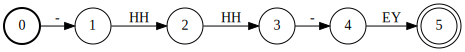

In [72]:
test_phons = create_frame_acceptor("- HH HH - EY")
test_phons

In [96]:
acoustic_fst = pfst.Fst.read("FST/sausage_probs.fst")

In [109]:
complete_fst = pfst.compose(acoustic_fst, LG)

In [116]:
short_path = pfst.shortestpath(complete_fst)

In [121]:
start_string = ""
prev_state = short_path.start()
while True:
    arc_list = [arc for arc in short_path.arcs(prev_state)]
    if not arc_list:
        break
    
    arc = arc_list[0]
    arc_text = short_path.output_symbols().find(arc.olabel)
    if arc_text != "<eps>":
        start_string = start_string + " " + arc_text
    
    prev_state = arc.nextstate

In [122]:
start_string

' the'

In [127]:
help(pfst)

Help on module pywrapfst:

NAME
    pywrapfst - Python interface to the FST scripting API.

FILE
    /usr/local/lib/python2.7/site-packages/pywrapfst.so

DESCRIPTION
    Operations which construct new FSTs are implemented as traditional functions, as
    are two-argument boolean functions like `equal` and `equivalent`. Destructive
    operations---those that mutate an FST, in place---are instance methods, as is
    `write`. Operator overloading is not used. The following example, based on
    Mohri et al. 2002, shows the construction of an ASR system given a pronunciation
    lexicon L, grammar G, a transducer from context-dependent phones to
    context-independent phones C, and an HMM set H:
    
      L = fst.Fst.read("L.fst")
      G = fst.Fst.read("G.fst")
      C = fst.Fst.read("C.fst")
      H = fst.Fst.read("H.fst")
      LG = fst.determinize(fst.compose(L, G))
      CLG = fst.determinize(fst.compose(C, LG))
      HCLG = fst.determinize(fst.compose(H, CLG))
      HCLG.minimize(

In [135]:
pfst.plus(pfst.Weight.O(LG.weight_type()), pfst.Weight.Zero(LG.weight_type()))

<tropical Weight Infinity at 0x7f9c45923b10>

In [137]:
help(pfst.Arc)

Help on class Arc in module pywrapfst:

class Arc(__builtin__.object)
 |  Arc(ilabel, olabel, weight, nextstate)
 |  
 |  This class represents an arc while remaining agnostic about the underlying arc
 |  type.  Attributes of the arc can be accessed or mutated, and the arc can be
 |  copied.
 |  
 |  Attributes:
 |    ilabel: The input label.
 |    olabel: The output label.
 |    weight: The arc weight.
 |    nextstate: The destination state for the arc.
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      x.__init__(...) initializes x; see help(type(x)) for signature
 |  
 |  __repr__(...)
 |      x.__repr__() <==> repr(x)
 |  
 |  copy(...)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  ilabel
 |  
 |  nextstate
 |  
 |  olabel
 |  
 |  weight
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  __new__ = <built-in metho

In [140]:
log

NameError: name 'ln' is not defined